# Building a WaveNet

## Imports + dataset construction

In [9]:
from collections import deque
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import bisect


words = open('names.txt').read().splitlines()

# Utility dicts
stoi = {c:i+1 for i,c in enumerate(sorted(set("".join(words))))}
stoi["."] = 0
itos = {i:c for c,i in stoi.items()}

In [10]:
# Create the dataset
CONTEXT_WINDOW = 8
def build_dataset(wds):
    X,Y = [],[]
    for w in wds:
        window = deque([0]*CONTEXT_WINDOW,maxlen=CONTEXT_WINDOW)
        for c in w + ".":
            ix = stoi[c]
            X.append(list(window))
            Y.append(ix)
            # print(''.join(itos[i] for i in window), '--->', itos[ix])
            window.append(ix)
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape,Y.shape)
    return X,Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


# Model

In [21]:
class Linear:
    def __init__(self, ni: int, no: int, bias: bool=True):
        self.w = torch.randn((ni,no)) / ni **0.5
        self.bias = torch.randn(no) * 0 if bias else None

    def __call__(self, x):
        self.output = x @ self.w + (self.bias if self.bias is not None else 0)
        return self.output

    def parameters(self):
        return [self.w] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, ni: int, eps: float=1e-5, momentum: float=0.1):
        self.eps = eps
        self.momentum = momentum
        self.ni = ni
        self.gamma = torch.ones(ni)
        self.beta = torch.zeros(ni)
        self.training = True
        self.running_mean = torch.zeros(ni)
        self.running_var = torch.ones(ni)

    def __call__(self, x):
        if self.training:
            # If we are batch norming 2/3dm we pass different dims.
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        x_standard = (x - xmean) / (xvar + self.eps)**0.5
        self.output = self.gamma * x_standard + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.output

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.output = torch.tanh(x)
        return self.output
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings: int, embedding_dim: int):
        self.weight = torch.randn(num_embeddings, embedding_dim)

    def __call__(self, ix):
        # index the embedding tensor to get the feature vectors
        self.output = self.weight[ix]
        return self.output

    def parameters(self):
        return [self.weight]

class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.output = x
    return self.output

  def parameters(self):
    return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

N = 24
VOCAB_SIZE = 27
HIDDEN_SIZE = 100

layers = [
    Embedding(VOCAB_SIZE, N),
    FlattenConsecutive(2),Linear(N * 2, HIDDEN_SIZE, bias = False), BatchNorm1d(HIDDEN_SIZE), Tanh(),
    FlattenConsecutive(2),Linear(HIDDEN_SIZE * 2, HIDDEN_SIZE, bias = False), BatchNorm1d(HIDDEN_SIZE), Tanh(),
    FlattenConsecutive(2),Linear(HIDDEN_SIZE * 2, HIDDEN_SIZE, bias = False), BatchNorm1d(HIDDEN_SIZE), Tanh(),
    Linear(HIDDEN_SIZE, VOCAB_SIZE),
]

model = Sequential(layers)

with torch.no_grad():
    layers[-1].w *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.w *= 5/3

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


48775


In [ ]:
milestones = [50000, 75000, 100000]
values = [0.1, 0.05, 0.03,0.01]
losses = []
updates = []

for i in range(200000):
    # Indices of the batch
    ix = torch.randint(0,Xtr.shape[0],(64,))


    # Forward through all layers
    x = Xtr[ix]
    x = model(x)

    loss = F.cross_entropy(x, Ytr[ix])
    # Backward
    for layer in layers:
        layer.output.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()
    lr = values[bisect.bisect_right(milestones, i)]
    for p in parameters:
        p.data -= p.grad * lr

    # Stat tracking
    if i % 10000 == 0:
        print(f"{i}: {loss.item():.3f}")
    losses.append(loss.item())
    with torch.no_grad():
        updates.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    # break


0: 3.298


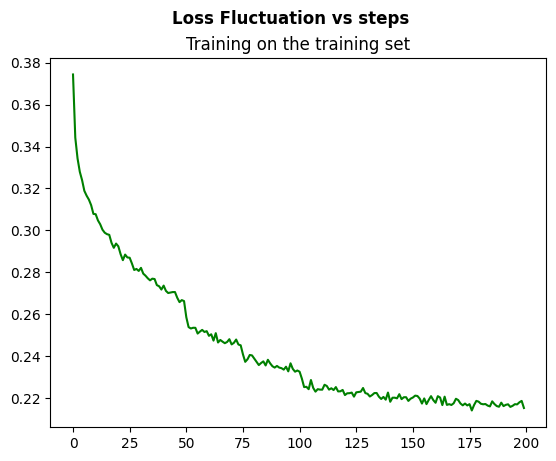

In [18]:
plt.plot(torch.tensor(losses).log10().view(-1,1000).mean(1), "g" )
plt.suptitle("Loss Fluctuation vs steps", fontweight='bold')
plt.title("Training on the training set")
plt.show()

In [19]:
for layer in model.layers:
  layer.training = False

In [20]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.6178685426712036
val 2.0621540546417236


In [8]:
# sample from the model
for _ in range(200):

    out = []
    context = [0] * CONTEXT_WINDOW# initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))

      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

zamona.
lennie.
aalim.
tara.
munberkin.
myannbe.
ru.
maasime.
khaden.
vinzle.
omino.
shernett.
destrion.
jur.
jazarina.
chantoo.
maarie.
ronelyn.
kalessandella.
gevarleo.
candee.
cynny.
zuley.
jalanna.
khaiiya.
jimisch.
hafiln.
jaicie.
elloa.
avins.
jhayah.
deulah.
gerdene.
kylee.
crosten.
rogan.
jofere.
denikea.
ellite.
amauri.
jubela.
kiallely.
xaylee.
daeshaal.
caelynni.
jerevion.
slahorian.
manaa.
nayliria.
chayne.
novalia.
lairah.
sadah.
zamia.
ilrhil.
munsare.
nomoslei.
sunthe.
jaxtyn.
machi.
miadlynn.
christon.
rubyran.
zenily.
wechey.
zayii.
annia.
kennevet.
afgin.
rylee.
karinh.
leicie.
srigriny.
covishon.
anstion.
layler.
yemyrlyns.
jadiannes.
narcos.
hilla.
brandee.
cadoie.
johlee.
taona.
friccie.
jus.
adaleno.
ochwyn.
devaithig.
romy.
jherri.
jeaily.
amalei.
rodi.
miaila.
joseua.
carlin.
mannzee.
isah.
niky.
rillimo.
srugh.
lailon.
assav.
ewyns.
mikat.
kirshan.
lilith.
zyie.
zayi.
myeke.
quint.
wesslee.
rindly.
angeonya.
taeline.
saicha.
raveen.
nika.
maxsam.
yaus.
esvikhol

Using a hierarchical model, we can essentially process in batch dimensions.

e.g. instead of (4,80) @ (80,200), we can do (4,4,20) @ (20,200) -> (4,4,200)

we effectively have 2 batch dimensions, the first 1 4, and the second one 4 which separates our 8 characters into bigram representations before passing to the linear layer.